<a href="https://colab.research.google.com/github/pengushow/Pattern-Recognition/blob/main/%E3%80%8CCGU_course_1_For_Student_ipynb%E3%80%8D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 深度學習實作 影像分類 Image Classification
1. 先將
https://drive.google.com/file/d/18GODCM056MhpiwzHLPW3lFZ2lWI7BaIt/view?usp=sharing
這裡的檔案放到到你目前使用的雲端硬碟






---
## 任務: 做「6類垃圾分類」包含:厚紙板(cardboard)、玻璃(glass)、金屬(metal)、紙類(paper)、塑膠(plastic)、垃圾(trash)
將GarbageClassification.zip解壓縮，解壓縮之後，train資料夾之中的照片訓練一個神經網路。用train分割的資料夾的照片做validation，目標是訓練出一個 training accuracy和 val_accuracy都高的網路。

---

#備註
本專案參考下面連結的教學 https://www.tensorflow.org/tutorials/images/classification 

# 解壓縮上傳到server的檔案
GargabeClassification.zip檔，執行下面這一塊Cell之後，會解壓縮到GarbageClassification資料夾，其中有兩個資料夾分別為train和test

In [ ]:
#連動雲端硬碟
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## 解壓縮zip檔
import zipfile
data_file = "/content/drive/MyDrive/GarbageClassification.zip"
directory_to_extract_to ="/content/"  #解壓縮後儲存的地方

with zipfile.ZipFile(data_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)


---

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL 
from PIL import Image
import tensorflow as tf
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import LeakyReLU
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import  img_to_array, load_img
import seaborn as sns
import cv2

In [64]:
import pathlib

data_dir = pathlib.Path("/content/GarbageClassification/train")
test_dir = pathlib.Path("/content/GarbageClassification/test")

In [ ]:
image_count = len(list(data_dir.glob('**/*.jpg')))

print(image_count)

2467


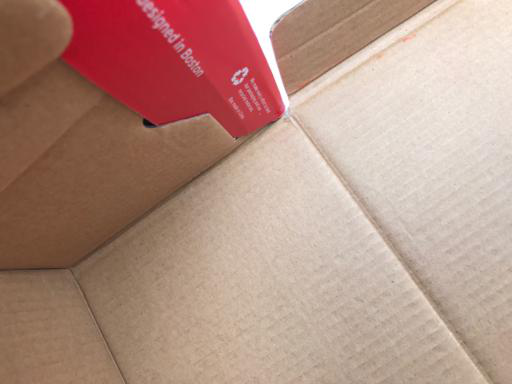

In [ ]:
cardboard = list(data_dir.glob('cardboard/*'))
PIL.Image.open(str(cardboard[0]))

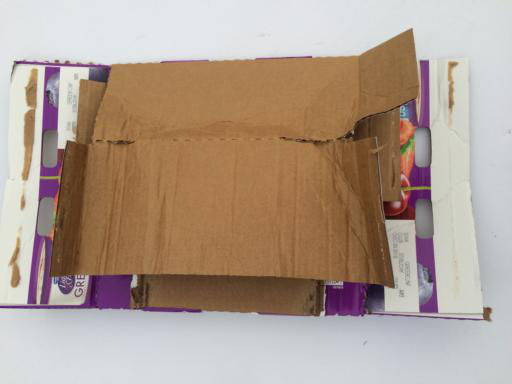

In [ ]:
PIL.Image.open(str(cardboard[1]))

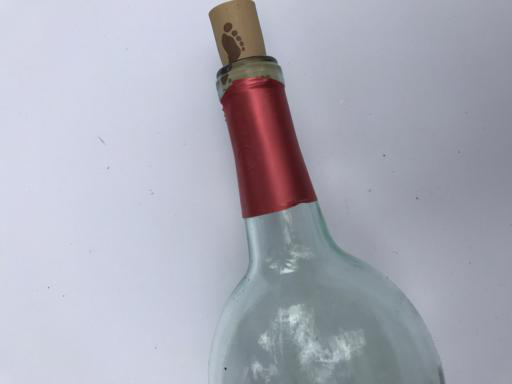

In [ ]:
glass = list(data_dir.glob('glass/*'))
PIL.Image.open(str(glass[0]))

In [65]:
batch_size = 32
img_height = 180
img_width = 180

In [66]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
type(train_ds)

Found 2594 files belonging to 6 classes.
Using 2076 files for training.


tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
# trash_dir=pathlib.Path('/content/GarbageClassification/train/trash')

# trash_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   trash_dir,
#   image_size=(img_height, img_width))
#   #batch_size=batch_size)


Found 0 files belonging to 0 classes.


ValueError: ignored

In [67]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2594 files belonging to 6 classes.
Using 518 files for validation.


In [68]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 60 files belonging to 6 classes.


In [ ]:
tf.keras.preprocessing.image_dataset_from_directory

<function keras.preprocessing.image_dataset.image_dataset_from_directory>

In [ ]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [69]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

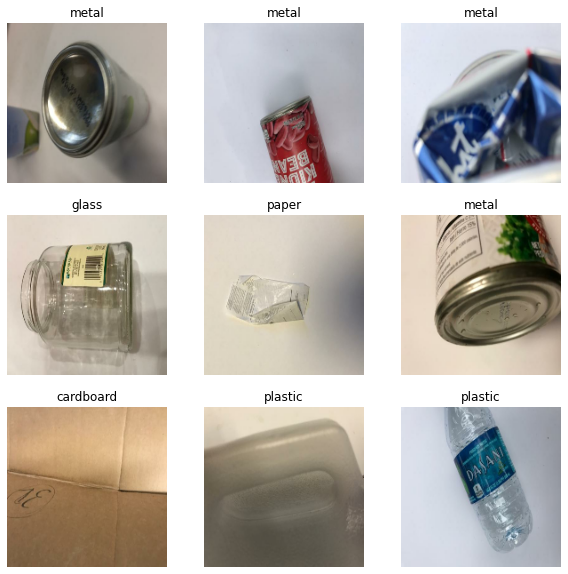

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255) #normalization

In [ ]:
#lambda:建立函式
#map(function, iterable):透過function映射到另外一個空間
#https://ithelp.ithome.com.tw/articles/10218124
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 


0.0 1.0


In [ ]:
###############
tnormalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.9979999


In [ ]:
vnormalized_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(vnormalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.008786998 0.9942298


In [ ]:
num_classes = 6
#.Conv2D:filters，kernel_size，
#.Dense:全連接層
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dense(num_classes)
])

In [ ]:
opt = keras.optimizers. Adagrad(learning_rate=0.002)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

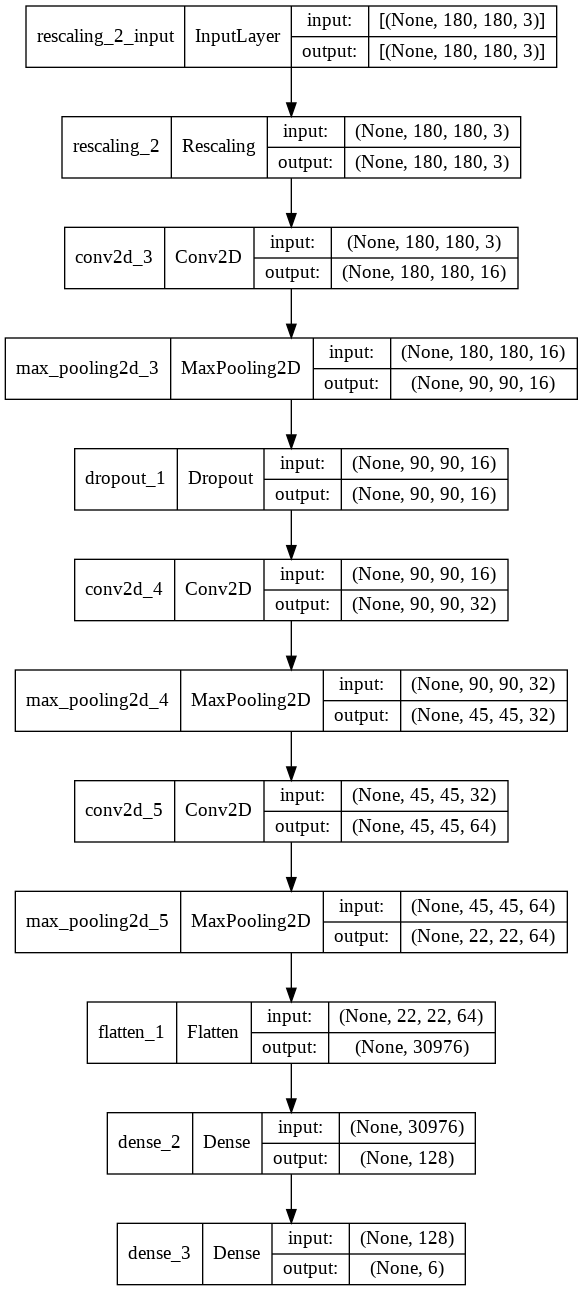

In [ ]:
tf.keras.utils.plot_model(model,"multi_input_and_output_model.png", show_shapes=True)

In [ ]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
62/62 [==============================] - 14s 67ms/step - loss: 1.7169 - accuracy: 0.2690 - val_loss: 1.5743 - val_accuracy: 0.3611
Epoch 2/30
62/62 [==============================] - 3s 44ms/step - loss: 1.3945 - accuracy: 0.4524 - val_loss: 1.3741 - val_accuracy: 0.4767
Epoch 3/30
62/62 [==============================] - 3s 44ms/step - loss: 1.1849 - accuracy: 0.5436 - val_loss: 1.2814 - val_accuracy: 0.4665
Epoch 4/30
62/62 [==============================] - 3s 44ms/step - loss: 1.0405 - accuracy: 0.6023 - val_loss: 1.1509 - val_accuracy: 0.5639
Epoch 5/30
62/62 [==============================] - 3s 44ms/step - loss: 0.8598 - accuracy: 0.6829 - val_loss: 1.0746 - val_accuracy: 0.6004
Epoch 6/30
62/62 [==============================] - 3s 45ms/step - loss: 0.7666 - accuracy: 0.7229 - val_loss: 0.9979 - val_accuracy: 0.6247
Epoch 7/30
62/62 [==============================] - 3s 44ms/step - loss: 0.5988 - accuracy: 0.7852 - val_loss: 1.1179 - val_accuracy: 0.6146
Epoch 8/30
6

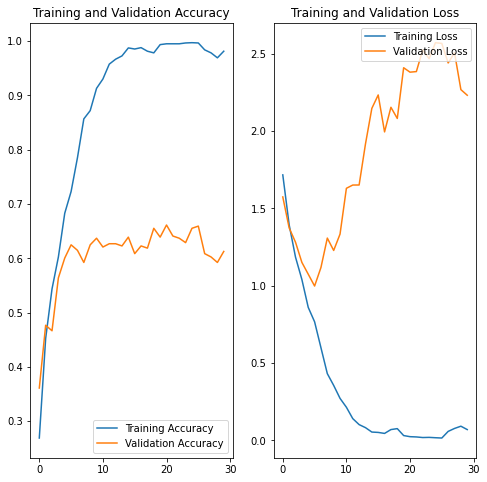

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [70]:
#影像資料增補
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
# img = cv2.imread('/content/GarbageClassification/train/trash/trash112.jpg')

# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#格式必須為：(sample數, channels, height, width)

#img = img.reshape((1,) + img.shape)

In [ ]:
# for batch in datagen.flow(img, batch_size=10,
# save_to_dir='/content/GarbageClassification/test/trash', save_prefix='new', save_format='jpeg')

In [ ]:
# import shutil

# pathTest = r"/content/GarbageClassification"

# try:
#     shutil.rmtree(pathTest)
# except OSError as e:
#     print(e)
# else:
#     print("The directory is deleted successfully")

The directory is deleted successfully


In [ ]:
from PIL import Image
import cv2
trashA = list(data_dir.glob('trash/*'))
#PIL.Image.open(str(glass[0]))
i=1
for i in trashA:
  print(i)
  image=cv2.imread(str(i))
  #image=image.astype('uint8')
  #images = np.array(image)
  #images=cv2.resize(image,(180,180))
  images=cv2.resize(image.astype(float),(180,180))
  print(image.shape)
  print(images.shape)
  augmented_images = data_augmentation(images)
  #print('augmented_images1',augmented_images)  
  print('augmented_images1',augmented_images.shape)

  newepath=str(i).replace(".jpg", "new.jpg")
  augmented_images =augmented_images[0].numpy().astype("uint8")

  print('augmented_images',augmented_images.shape)

  #print('augmented_images2',augmented_images)
  pil_image=Image.fromarray(augmented_images)
  pil_image.save(newepath)

/content/GarbageClassification/train/trash/trash22.jpg
(384, 512, 3)
(180, 180, 3)
augmented_images1 (180, 180, 3)
augmented_images (180, 3)
/content/GarbageClassification/train/trash/trash18.jpg
(384, 512, 3)
(180, 180, 3)
augmented_images1 (180, 180, 3)
augmented_images (180, 3)
/content/GarbageClassification/train/trash/trash75.jpg
(384, 512, 3)
(180, 180, 3)
augmented_images1 (180, 180, 3)
augmented_images (180, 3)
/content/GarbageClassification/train/trash/trash99.jpg
(384, 512, 3)
(180, 180, 3)
augmented_images1 (180, 180, 3)
augmented_images (180, 3)
/content/GarbageClassification/train/trash/trash46.jpg
(384, 512, 3)
(180, 180, 3)
augmented_images1 (180, 180, 3)
augmented_images (180, 3)
/content/GarbageClassification/train/trash/trash123.jpg
(384, 512, 3)
(180, 180, 3)
augmented_images1 (180, 180, 3)
augmented_images (180, 3)
/content/GarbageClassification/train/trash/trash92.jpg
(384, 512, 3)
(180, 180, 3)
augmented_images1 (180, 180, 3)
augmented_images (180, 3)
/content/Gar

In [ ]:
images.shape


(180, 180, 3)

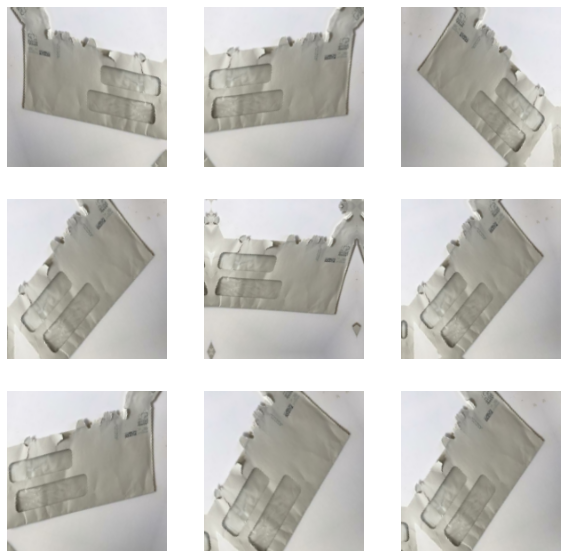

In [ ]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    #print('augmented_images1',augmented_images.shape)
    b=augmented_images[0].numpy().astype("uint8")
    #print('augmented_images',b.shape)
    plt.axis("off")
  #print(class_names[labels[0]])

In [95]:
modelA = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 4, padding='same', activation='relu'),
  #layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),

  layers.Dense(num_classes)
])

In [96]:
modelA.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [97]:
modelA.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        8224      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [98]:
epochs = 30
#class_weight={0:2. , 1:2. , 2:2. , 3:2. , 4:1. , 5:5.}
history = modelA.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  class_weight=class_weight,
  epochs=epochs
 
)

Epoch 1/30
65/65 [==============================] - 5s 65ms/step - loss: 3.4733 - accuracy: 0.2558 - val_loss: 1.5878 - val_accuracy: 0.3166
Epoch 2/30
65/65 [==============================] - 4s 61ms/step - loss: 3.0643 - accuracy: 0.3603 - val_loss: 1.3471 - val_accuracy: 0.4633
Epoch 3/30
65/65 [==============================] - 4s 61ms/step - loss: 2.5809 - accuracy: 0.4769 - val_loss: 1.1884 - val_accuracy: 0.5521
Epoch 4/30
65/65 [==============================] - 4s 61ms/step - loss: 2.5606 - accuracy: 0.4774 - val_loss: 1.3015 - val_accuracy: 0.5154
Epoch 5/30
65/65 [==============================] - 4s 61ms/step - loss: 2.3156 - accuracy: 0.5438 - val_loss: 1.1229 - val_accuracy: 0.5753
Epoch 6/30
65/65 [==============================] - 4s 61ms/step - loss: 2.0789 - accuracy: 0.5910 - val_loss: 1.1379 - val_accuracy: 0.6081
Epoch 7/30
65/65 [==============================] - 4s 61ms/step - loss: 1.9726 - accuracy: 0.6074 - val_loss: 1.3057 - val_accuracy: 0.5347
Epoch 8/30
65

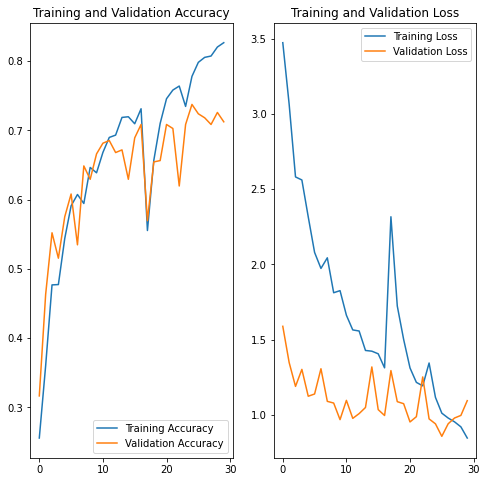

In [99]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This image most likely belongs to cardboard with a 88.52 percent confidence.


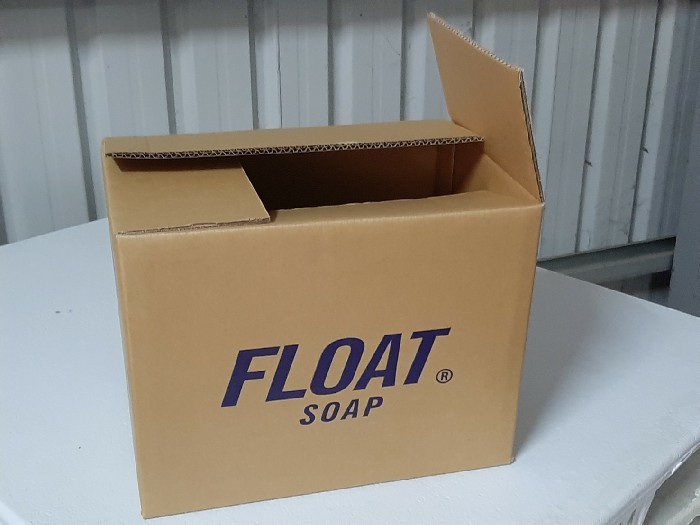

In [100]:
#glass_url = "https://ct.yimg.com/xd/api/res/1.2/PmTV53nlExE0xwUNVLyHXQ--/YXBwaWQ9eXR3YXVjdGlvbnNlcnZpY2U7aD0zNzQ7cT04NTtyb3RhdGU9YXV0bzt3PTQwMA--/https://s.yimg.com/ob/image/c2c96a5c-9b1d-4da7-875a-23daae8e656f.jpg"
#glass_url = "http://pic.pimg.tw/d2watasia/normal_4a1376bfde860.jpg"
glass_url = "https://www.hcbox.com.tw/uploads/images/6fc95b8835cb4bf99ebd8b1095357dc9.jpg"
new_test_path = tf.keras.utils.get_file('6fc95b8835cb4bf99ebd8b1095357dc9', origin=glass_url)

img = keras.preprocessing.image.load_img(
    new_test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = modelA.predict(img_array)
#print(predictions[0])
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(new_test_path)

In [101]:

#%%
dict_labels = {"plastic":4, "paper":3,"cardboard":0,"glass":1,
               "metal":2,"trash":5}
size = (180,180) #由於原始資料影像大小不一，因此制定一個統一值
images=[]
labels_hot=[]
labels=[]
for folders in glob.glob("/content/GarbageClassification/test/*"):



    for filename in os.listdir(folders):
      label = os.path.basename(folders)
      className = np.array(label)
      #print(className,filename)
      #print(className)
      #img=load_img(os.path.join(folders,filename))
      img=cv2.imread(os.path.join(folders,filename))
      
      #print(images)
      img=cv2.resize(img,size)
      img=img.astype('uint8')
      if img is not None:
          if label is not None:
              labels.append(className)
              #labels_hot.append(dict_labels[label])
          #print(type(labels))
          #x=img_to_array(img)
          #x=x/255
          #rrayx = np.resize(x, (1,180, 180, 3))
          #images=np.append(images, x)
          
          #img=np.expand_dims(img, axis=2)
          
          images.append(img)
          #print(img.shape)
          #images.append(img)
          #print(images)
          #print(x)
          
                    #nbofdata_i+=1
     
    #labels_hot=np.array(labels_hot)
    # print("images.shape={}, labels_hot.shape=={}".format(images.shape, labels_hot.shape))    
    imagesavepath='All_Dataset/'
    if not os.path.exists(imagesavepath):
        os.makedirs(imagesavepath)
    np.save(imagesavepath+'{}_images.npy'.format(label),images)    
    np.save(imagesavepath+'{}_label.npy'.format(label),labels)    
    #np.save(imagesavepath+'{}_labels_hot.npy'.format(label),labels_hot)
    print('{} files has been saved.'.format(label))
images=np.array(images)

labels=np.array(labels)
#print(images)
#images = np.reshape(images, (60,180, 180, 3)) 

trash files has been saved.
cardboard files has been saved.
paper files has been saved.
metal files has been saved.
glass files has been saved.
plastic files has been saved.


In [ ]:
#%%
dict_labels = {"plastic":4, "paper":3,"cardboard":0,"glass":1,
               "metal":2,"trash":5}
size = (180,180) #由於原始資料影像大小不一，因此制定一個統一值
images=[]
labels_hot=[]
labels=[]
for folders in glob.glob("/content/GarbageClassification/test/*"):

    for filename in os.listdir(folders):
      label = os.path.basename(folders)
      className = np.array(label)
    
      img=cv2.imread(os.path.join(folders,filename))
      
      img=cv2.resize(img,size)
      img=img.astype('uint8')
      if img is not None:
          if label is not None:
              labels.append(className)
       
          images.append(img)
          
    imagesavepath='All_Dataset/'
    if not os.path.exists(imagesavepath):
        os.makedirs(imagesavepath)
    np.save(imagesavepath+'{}_images.npy'.format(label),images)    
    np.save(imagesavepath+'{}_label.npy'.format(label),labels)    
    print('{} files has been saved.'.format(label))
images=np.array(images)

labels=np.array(labels)


In [102]:

Y=[]
lname=[]
y_predict = modelA.predict(images)
y_test_pred = np.argmax(y_predict, axis=1)
for i in range(60):
  Y.append(dict_labels[labels[i]])

for j in y_test_pred:
  lname.append(class_names[j])


print(lname,y_test_pred)

['plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'metal', 'plastic', 'plastic', 'plastic', 'metal', 'metal', 'metal', 'metal', 'metal', 'plastic', 'plastic', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'paper', 'plastic', 'metal', 'plastic', 'glass', 'metal', 'plastic', 'plastic', 'paper', 'metal', 'metal', 'plastic', 'plastic', 'plastic', 'glass', 'plastic', 'plastic', 'plastic', 'glass', 'glass', 'plastic', 'glass', 'plastic', 'metal', 'glass', 'metal', 'glass', 'plastic', 'plastic', 'metal', 'plastic', 'plastic', 'plastic'] [4 4 4 4 4 2 4 4 4 2 2 2 2 2 4 4 2 2 2 2 2 2 2 2 2 2 2 3 4 2 4 1 2 4 4 3 2
 2 4 4 4 1 4 4 4 1 1 4 1 4 2 1 2 1 4 4 2 4 4 4]


In [103]:

Y1=[]
#img_array = tf.expand_dims(img_array, 0)
y1_predict = model.predict(images)

y1_test_pred = np.argmax(y1_predict, axis=1)

# score = tf.nn.softmax(y_predict[7])
# lname=class_names[np.argmax(score)]
for i in range(60):
  Y1.append(dict_labels[labels[i]])
print(Y1,y1_test_pred)

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4] [4 1 1 4 4 4 1 4 2 4 1 0 2 0 1 2 0 4 4 4 3 3 3 3 2 3 4 0 4 0 4 2 4 4 4 1 3
 2 4 4 4 4 1 1 4 1 1 4 1 4 1 4 4 1 4 4 2 1 4 4]


In [104]:
arY=np.array(Y)
loss,score=modelA.evaluate(images,arY)

2/2 [==============================] - 0s 27ms/step - loss: 7.3142 - accuracy: 0.2167


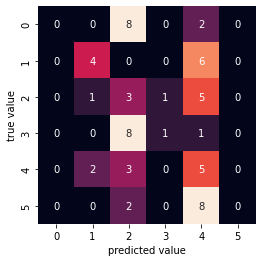

In [105]:
mat = confusion_matrix(Y,y_test_pred)

#print("accuracy score:", accuracy_score(Y,y_test_pred))

sns.heatmap(mat,square= True, annot=True, cbar= False)
plt.xlabel("predicted value")
plt.ylabel("true value")
plt.show()

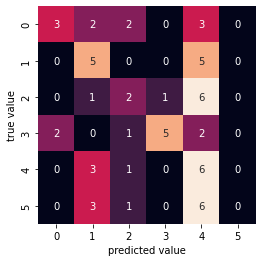

In [106]:
mat = confusion_matrix(Y1,y1_test_pred)

#print("accuracy score:", accuracy_score(Y,y_test_pred))

sns.heatmap(mat,square= True, annot=True, cbar= False)
plt.xlabel("predicted value")
plt.ylabel("true value")
plt.show()